## Problem statement:

#### CT Scan Image Classification

# Data Overview
This dataset contains 1252 CT scans that are positive for SARS-CoV-2 infection (COVID-19) and 1230 CT scans for patients non-infected by SARS-CoV-2, 2482 CT scans in total. These data have been collected from real patients in hospitals from Sao Paulo, Brazil. The aim of this dataset is to encourage the research and development of artificial intelligent methods which are able to identify if a person is infected by SARS-CoV-2 through the analysis of his/her CT scans.

##### Download this data from here - 
https://drive.google.com/drive/folders/1WOeodRmv1Mw5Cswuip3nUIi6ViQWKpo_?usp=sharing


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Conv2D, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications import ResNet101, ResNet152, ResNet50
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping


# Supress info, warnings and error messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [6]:
disease_types = ['COVID', 'non-COVID']

train_dir = data_dir = '/content/drive/MyDrive/Capstone_project'
train_data = []

for index, sp in enumerate(disease_types):
  for file in os.listdir(os.path.join(train_dir, sp)):
    train_data.append([sp + "/" + file, index, sp])

train = pd.DataFrame(train_data, columns = ['File', 'ID', 'Disease Type'])

,File,ID,Disease Type
0,non-COVID/Non-Covid (392).png,1,non-COVID
1,COVID/Covid (379).png,0,COVID
2,non-COVID/Non-Covid (99).png,1,non-COVID
3,COVID/Covid (171).png,0,COVID
4,COVID/Covid (635).png,0,COVID
...,...,...,...
2476,COVID/Covid (154).png,0,COVID
2477,COVID/Covid (478).png,0,COVID
2478,non-COVID/Non-Covid (796).png,1,non-COVID
2479,non-COVID/Non-Covid (319).png,1,non-COVID


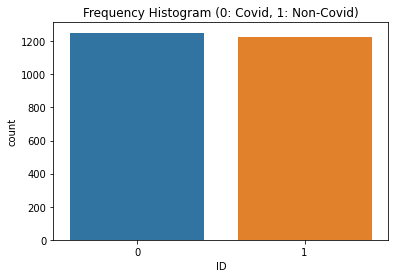

In [7]:
Seed = 45
train = train.sample(frac = 1, replace = False, random_state = Seed)

# Reset Index Numbers of dataset
train = train.reset_index(drop = True)

sns.countplot(x = 'ID', data = train).set_title("Frequency Histogram (0: Covid, 1: Non-Covid)")
train

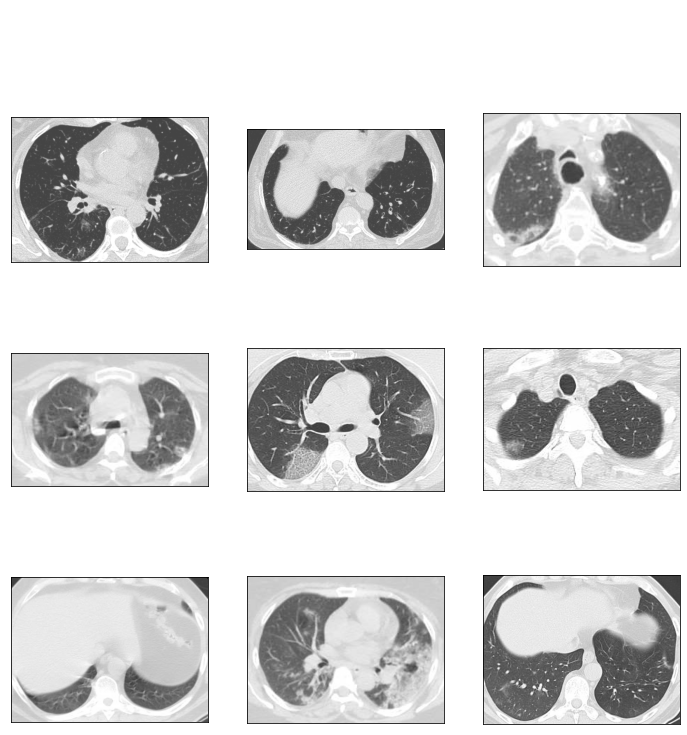

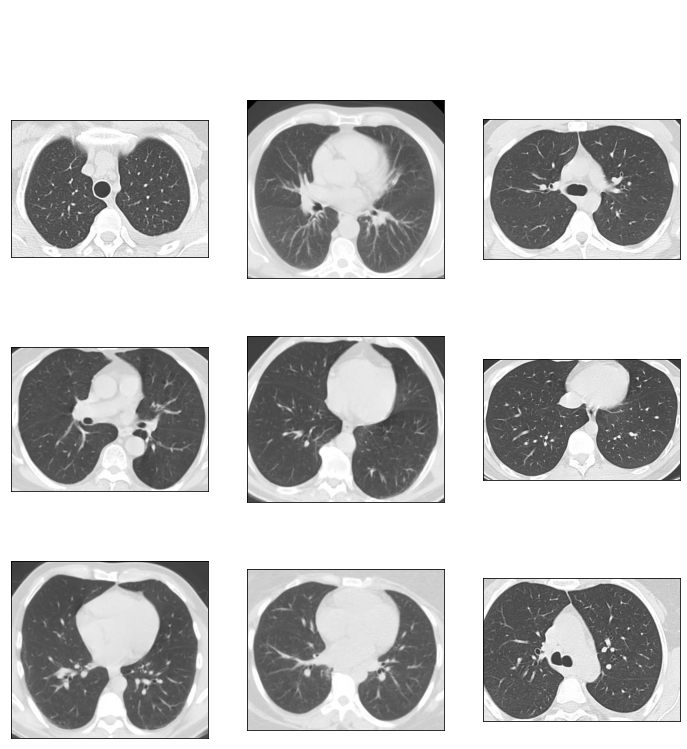

In [8]:
from collections.abc import ValuesView
def plot_defects(defect_types, rows, cols):
  fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
  defect_files = train['File'][train['Disease Type'] == defect_types].values
  n = 0
  fig.suptitle(defect_types, fontsize = 22, color = "white")
  for i in range(rows):
    for j in range(cols):
      image_path = os.path.join(data_dir, defect_files[n])
      ax[i, j].set_xticks([])
      ax[i, j].set_yticks([])
      ax[i, j].imshow(cv2.imread(image_path))
      n = n+1

plot_defects('COVID', 3, 3)
plot_defects('non-COVID', 3, 3)
     

In [9]:
IMAGE_SIZE = 224

# OpenCV function to load colored image
def read_image(filepath):
  return cv2.imread(os.path.join(data_dir, filepath))

#OpenCV Function to resize an image
def resize_image(image, image_size):
  return cv2.resize(image.copy(), image_size, interpolation = cv2.INTER_AREA)

In [10]:
  X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

for i, file in enumerate(train['File'].values):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

X_Train = X_train / 255.0   # Pixel normalization
print('Train Shape:', X_Train.shape)

Y_train = to_categorical(train['ID'].values, num_classes = 2)

print(Y_train)

Train Shape: (2481, 224, 224, 3)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


,File,ID,Disease Type
0,COVID/Covid (994).png,0,COVID
1,COVID/Covid (438).png,0,COVID
2,non-COVID/Non-Covid (1230).png,1,non-COVID
3,non-COVID/Non-Covid (846).png,1,non-COVID
4,non-COVID/Non-Covid (627).png,1,non-COVID
...,...,...,...
2476,non-COVID/Non-Covid (697).png,1,non-COVID
2477,non-COVID/Non-Covid (352).png,1,non-COVID
2478,non-COVID/Non-Covid (520).png,1,non-COVID
2479,COVID/Covid (1236).png,0,COVID


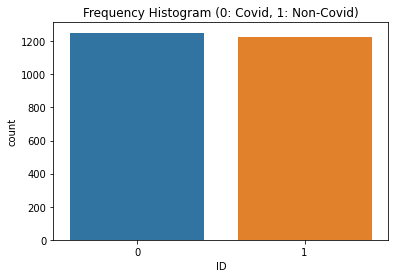

In [11]:

Seed = 45
train = train.sample(frac = 1, replace = False, random_state = Seed)

# Reset Index Numbers of dataset
train = train.reset_index(drop = True)

sns.countplot(x = 'ID', data = train).set_title("Frequency Histogram (0: Covid, 1: Non-Covid)")
train
     

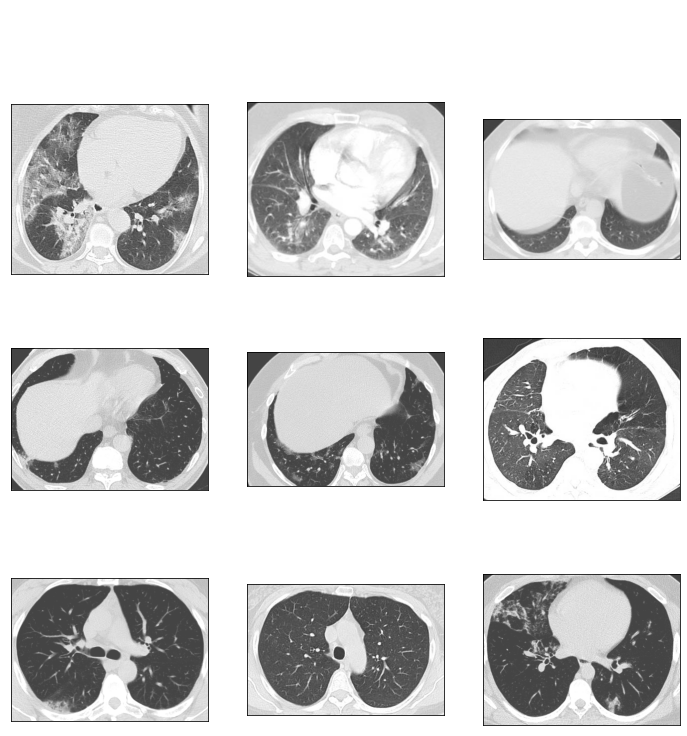

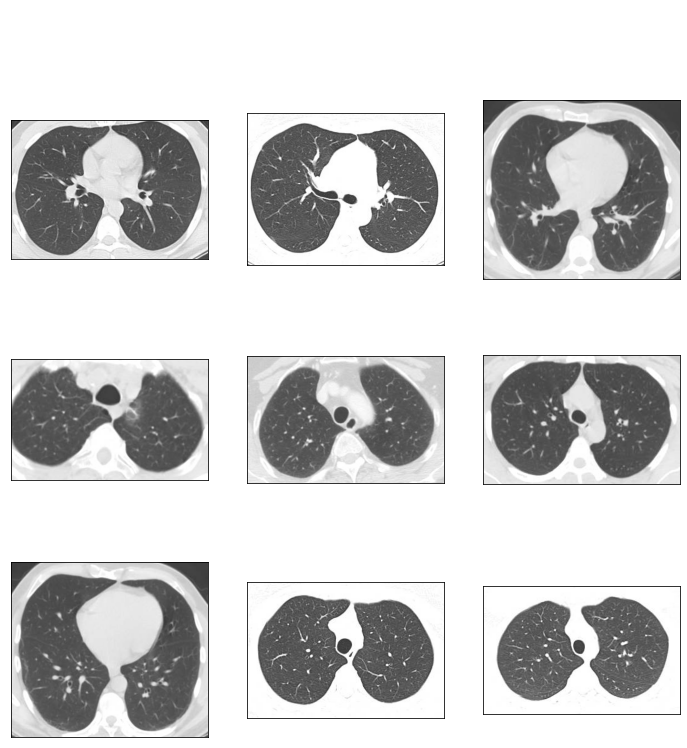

In [12]:
from collections.abc import ValuesView
def plot_defects(defect_types, rows, cols):
  fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
  defect_files = train['File'][train['Disease Type'] == defect_types].values
  n = 0
  fig.suptitle(defect_types, fontsize = 22, color = "white")
  for i in range(rows):
    for j in range(cols):
      image_path = os.path.join(data_dir, defect_files[n])
      ax[i, j].set_xticks([])
      ax[i, j].set_yticks([])
      ax[i, j].imshow(cv2.imread(image_path))
      n = n+1

plot_defects('COVID', 3, 3)
plot_defects('non-COVID', 3, 3)

In [13]:
IMAGE_SIZE = 224

# OpenCV function to load colored image
def read_image(filepath):
  return cv2.imread(os.path.join(data_dir, filepath))

#OpenCV Function to resize an image
def resize_image(image, image_size):
  return cv2.resize(image.copy(), image_size, interpolation = cv2.INTER_AREA)

In [14]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

for i, file in enumerate(train['File'].values):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

X_Train = X_train / 255.0   # Pixel normalization
print('Train Shape:', X_Train.shape)

Y_train = to_categorical(train['ID'].values, num_classes = 2)

print(Y_train)

Train Shape: (2481, 224, 224, 3)
[[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [15]:
# Dataframe split to trin and validation set(80% train and 20% validation)
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size = 0.2, random_state = Seed)

print(f'X_train : {X_train.shape}')
print(f'X_val : {X_val.shape}')
print(f'Y_train : {Y_train.shape}')
print(f'Y_val : {Y_val.shape}')

X_train : (1984, 224, 224, 3)
X_val : (497, 224, 224, 3)
Y_train : (1984, 2)
Y_val : (497, 2)


In [16]:
# Architectural function for ResNet152
def build_resnet152(IMAGE_SIZE, channels):

    resNet152 = ResNet152(weights = 'imagenet', include_top = False)

    input = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, channels))
    x = Conv2D(3, (3, 3), padding = 'same')(input)
    x = resNet152(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation = 'relu')(x)
    x = BatchNormalization()(x)
    
    output = Dense(2, activation = 'softmax')(x)
 
    # model
    model = Model(input, output)
    
    optimizer = Adam(learning_rate = 0.003, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.0)
    model.compile(loss = 'categorical_crossentropy',  # minimize the negative multinomial log-likelihood also known as the cross-entropy.
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    model.summary()
    
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       84        
                                                                 
 resnet152 (Functional)      (None, None, None, 2048)  58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               104908

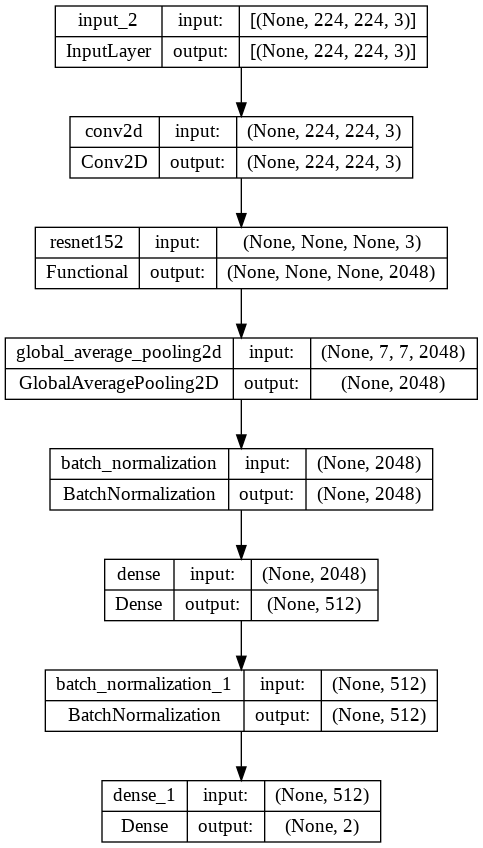

In [17]:
channels = 3

model = build_resnet152(IMAGE_SIZE, channels)
annealer = ReduceLROnPlateau(monitor = 'val_accuracy',  # Reduce learning rate when Validation accuracy remains constant
                             factor = 0.70,  # Rate by which the learning rate will decrease
                             patience = 5,   # number of epochs without improvement, after which the learning rate will decrease
                             verbose = 2,    # Display messages
                             min_lr = 1e-4   # lower limit on the learning rate.
                            )
checkpoint = ModelCheckpoint('model.h5', verbose = 2, save_best_only = True)  # Save neural network weights

# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range = 360, # Degree range for random rotations
                        width_shift_range = 0.2,   # Range for random horizontal shifts
                        height_shift_range = 0.2,  # Range for random vertical shifts
                        zoom_range = 0.2,          # Range for random zoom
                        horizontal_flip = True,    # Randomly flip inputs horizontally
                        vertical_flip = True)      # Randomly flip inputs vertically

datagen.fit(X_train)

plot_model(model, to_file = 'convnet.png', show_shapes = True, show_layer_names = True)

In [18]:
BATCH_SIZE = 18
EPOCHS = 50
callback = EarlyStopping(monitor='val_loss', patience=8)
# Fit of the model that includes the augmented images in terms of their characteristics
hist = model.fit(datagen.flow(X_train, Y_train, batch_size = BATCH_SIZE),
               steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
               epochs = EPOCHS,
               verbose = 1,
               callbacks = [callback],
               validation_data = (X_val, Y_val))

Epoch 1/50
110/110 [==============================] - 91s 584ms/step - loss: 0.6199 - accuracy: 0.7477 - val_loss: 0.8165 - val_accuracy: 0.5392
Epoch 2/50
110/110 [==============================] - 61s 556ms/step - loss: 0.4358 - accuracy: 0.8311 - val_loss: 2.1041 - val_accuracy: 0.5392
Epoch 3/50
110/110 [==============================] - 61s 555ms/step - loss: 0.3729 - accuracy: 0.8515 - val_loss: 1.0289 - val_accuracy: 0.5392
Epoch 4/50
110/110 [==============================] - 61s 556ms/step - loss: 0.3255 - accuracy: 0.8616 - val_loss: 0.6871 - val_accuracy: 0.5392
Epoch 5/50
110/110 [==============================] - 61s 555ms/step - loss: 0.3214 - accuracy: 0.8718 - val_loss: 0.9388 - val_accuracy: 0.3441
Epoch 6/50
110/110 [==============================] - 62s 561ms/step - loss: 0.2797 - accuracy: 0.8856 - val_loss: 1.0295 - val_accuracy: 0.4608
Epoch 7/50
110/110 [==============================] - 61s 557ms/step - loss: 0.2645 - accuracy: 0.8911 - val_loss: 0.5874 - val_ac

16/16 [==============================] - 6s 227ms/step
True Positive: 226
False Negative: 42
True Negative: 223
False Positive: 6
True Positive Rate: 0.8432835820895522
True Negative Rate: 0.9737991266375546

16/16 [==============================] - 4s 224ms/step - loss: 0.2783 - accuracy: 0.9034

Final Loss: 0.27826887369155884, Final Accuracy: 0.9034205079078674


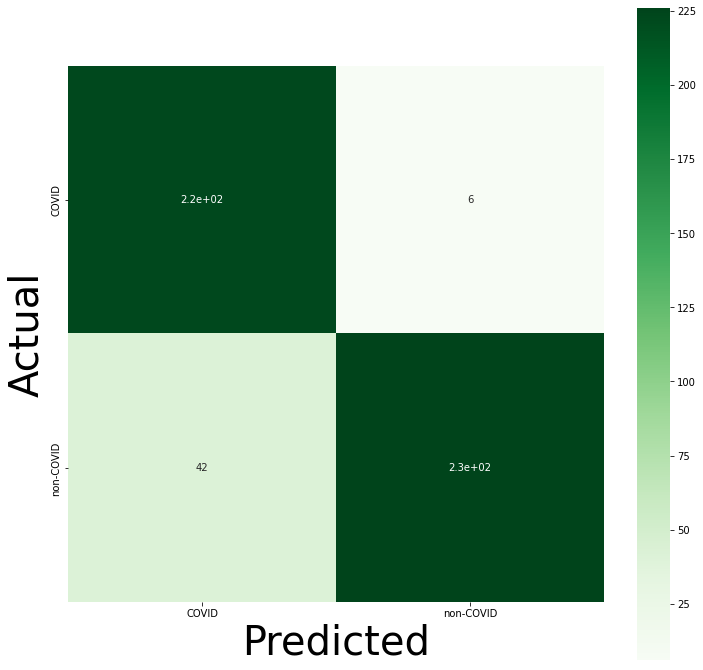

In [19]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_val, axis = 1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize = (12, 12))
ax = sns.heatmap(cm, cmap = plt.cm.Greens, annot = True, square = True, xticklabels = disease_types, yticklabels = disease_types)
ax.set_ylabel('Actual', fontsize = 40)
ax.set_xlabel('Predicted', fontsize = 40)


TP = cm[1][1]
print(f"True Positive: {TP}")


FN = cm[1][0]
print(f"False Negative: {FN}")

TN = cm[0][0]
print(f"True Negative: {TN}")

FP = cm[0][1]
print(f"False Positive: {FP}")

# Sensitivity, recall, or true positive rate
print(f"True Positive Rate: {TP / (TP + FN)}")

# Specificity or true negative rate
print(f"True Negative Rate: {TN / (TN + FP)}\n")

final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print(f"\nFinal Loss: {final_loss}, Final Accuracy: {final_accuracy}")

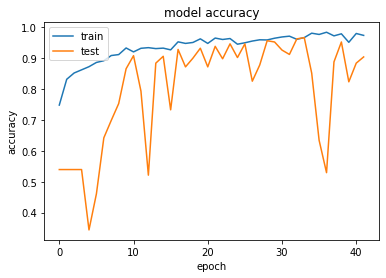

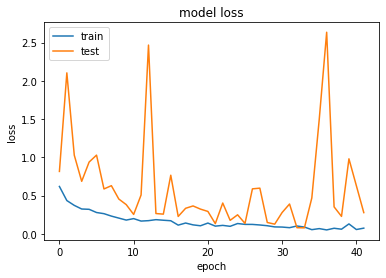

In [20]:
# Accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [21]:
import keras

In [22]:
import tensorflow.keras.preprocessing.image

In [23]:
keras.utils.load_img

<function keras.utils.image_utils.load_img(path, grayscale=False, color_mode='rgb', target_size=None, interpolation='nearest', keep_aspect_ratio=False)>

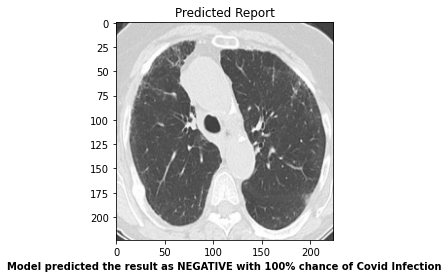

In [26]:
j = 0
k = 0
for i, label in enumerate(Y_pred):

    # Report for positive predicted cases
    if (np.argmax(Y_pred[i]) == 1.0) and (j < 1):
        plt.title("Predicted Report")
        plt.imshow(X_val[i].squeeze(), cmap="gray")
        plt.xlabel(
            "Model predicted the result as POSITIVE with "
            + str(round((np.max(label) * 100), 2))
            + "% chance of Covid Infection",
            fontweight="bold",
        )

        plt.show()
        #plt.savefig("output/figs/positive_predicted_report.png")
        j = j + 1

    # Report for negative predicted cases
    if (np.argmax(Y_pred[i]) == 0.0) and (k < 1):
        plt.title("Predicted Report")
        plt.imshow(X_val[i].squeeze(), cmap="gray")
        plt.xlabel(
            "Model predicted the result as NEGATIVE with "
            + str(round((np.min(label) * 100), 2))
            + "% chance of Covid Infection",
            fontweight="bold",
        )
        #plt.savefig("output/figs/negative_predicted_report.png")
        plt.show()
        k = k + 1

# if __name__ == "__main__":
#     # convert_to_npy()  #To convert image dataset into numpy arrays
#     AUC()  # To calculate AUC
#     test_cnn("no")  # CNN using Unsegmented CT scans
#     test_cnn("yes")  # CNN using segmented CT scans
